BloomTech Data Science

*Unit 2, Sprint 3, Module 2*

---


# Wrangle ML datasets

## Assignment
- Continue to clean and explore your data.
- For the evaluation metric you chose, what score would you get just by guessing?
- Can you make a fast, first model that beats guessing?

**We recommend that you use your portfolio project dataset for all assignments this sprint.**


## Business Scenario

Lending Club is an American lending marketplace that connects investors with borrowers. Instead of a bank or financial institution, investors act as lenders to fund borrowers loans.

Investors want to lend money to people who show a profile
of having a high probability of repayment. However, they face the challenge of predicting the risk of a borrower being unable to pay the loan back in full. They feel that the insights from existing data will help them in making data-driven decisions. So as data scientists, we will be building a model that can help in predicting whether a loan will not be paid back.

The dataset contains more than 9,500 loans with information about the borrower profile, loan structure and whether the loan was repaid. This data was extracted from [Kaggle - Loan Data](https://www.kaggle.com/datasets/itssuru/loan-data).

### Original Data Dictionary

|    | Variable          | Explanation                                                                                                             |
|---:|:------------------|:------------------------------------------------------------------------------------------------------------------------|
|  0 | credit_policy     | 1 if the customer meets the credit underwriting criteria; 0 otherwise.                                                  |
|  1 | purpose           | The purpose of the loan.                                                                                                |
|  2 | int_rate          | The interest rate of the loan (more risky borrowers are assigned higher interest rates).                                |
|  3 | installment       | The monthly installments owed by the borrower if the loan is funded.                                                    |
|  4 | log_annual_inc    | The natural log of the self-reported annual income of the borrower.                                                     |
|  5 | dti               | The debt-to-income ratio of the borrower (amount of debt divided by annual income).                                     |
|  6 | fico              | The FICO credit score of the borrower.                                                                                  |
|  7 | days_with_cr_line | The number of days the borrower has had a credit line.                                                                  |
|  8 | revol_bal         | The borrower's revolving balance (amount unpaid at the end of the credit card billing cycle).                           |
|  9 | revol_util        | The borrower's revolving line utilization rate (the amount of the credit line used relative to total credit available). |
| 10 | inq_last_6mths    | The borrower's number of inquiries by creditors in the last 6 months.                                                   |
| 11 | delinq_2yrs       | The number of times the borrower had been 30+ days past due on a payment in the past 2 years.                           |
| 12 | pub_rec           | The borrower's number of derogatory public records.                                                                     |
| 13 | not_fully_paid    | 1 if the loan is not fully paid; 0 otherwise.   

In [ ]:
# pip installs
!pip install pandas_profiling

In [ ]:
# Import Libraries, Dataset

import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from pandas_profiling import ProfileReport
from imblearn.over_sampling import SMOTE # to fix imbalance data
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split, cross_val_predict, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance

<ipython-input-2-8206d0d77cf8>:9: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


In [ ]:
# Path to dataset
DATA_PATH = '/content/loan_data.csv'

## I. Wrangle Data

In [ ]:
def wrangle(filepath):
  """
  This function performs data wrangling on the given dataset. It reads the dataset from the provided file path,
  replaces periods in column names with underscores, sets the data type of the 'purpose' column as category,
  handles outliers in the 'log_annual_inc' feature, performs feature engineering to create new columns,
  and drops the columns used for feature engineering to prevent data leakage.

  Parameters:
  - filepath (str): The file path of the dataset to be read.

  Returns:
  - loans (DataFrame): The cleaned and feature-engineered dataset.
  """
  loans = pd.read_csv(filepath)

  # Replacing period in column names with underscore
  loans.columns = loans.columns.str.replace(".", "_")

  # Set data type of 'purpose' column as category
  loans['purpose'] = loans['purpose'].astype('category')

  # Outliers - Finding the upper and lower bounds for the log_annual_inc feature
  def find_outlier_limits(col_name):
      Q1,Q3=loans[col_name].quantile([.25,.75])
      IQR=Q3-Q1
      low=Q1-(1.5* IQR)
      high=Q3+(1.5* IQR)
      return (high,low)

  high_log_annual_inc, low_log_annual_inc = find_outlier_limits('log_annual_inc')

  # Replacing outlier values for log_annual_inc, and installment with respective upper and lower limits
  loans.loc[loans['log_annual_inc'] > high_log_annual_inc,'log_annual_inc'] = high_log_annual_inc
  loans.loc[loans['log_annual_inc'] < low_log_annual_inc,'log_annual_inc'] = low_log_annual_inc

  # Feature engineering
  loans['credit_score_cat'] = np.where(loans['fico'] >= 670, 'Good/Excellent', 'Fair/Poor')
  loans['multiple_hard_inq'] = np.where(loans['inq_last_6mths'] > 2, 1, 0)
  loans['cr_util_rate'] = loans['revol_util'].apply(lambda x: 1 if (x > 30 or x == 0) else 0)

  # To avoid data leakage let's drop the columns used to do feature engineering
  loans.drop(columns=['fico', 'inq_last_6mths', 'revol_util'], inplace=True)

  return loans

In [ ]:
# Read data
loans = wrangle(DATA_PATH)

# Print a sample of the data
display(loans.sample(10))

<ipython-input-4-813e5cb05980>:17: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  loans.columns = loans.columns.str.replace(".", "_")


,credit_policy,purpose,int_rate,installment,log_annual_inc,dti,days_with_cr_line,revol_bal,delinq_2yrs,pub_rec,not_fully_paid,credit_score_cat,multiple_hard_inq,cr_util_rate
6308,1,all_other,0.1148,158.25,11.506907,23.76,6240.000000,57542,0,0,0,Good/Excellent,0,0
1234,1,all_other,0.1001,33.89,10.896739,11.56,4559.958333,8670,0,0,0,Good/Excellent,0,1
53,1,educational,0.0996,112.87,9.510445,16.44,1649.958333,2864,0,0,0,Good/Excellent,0,1
6513,1,credit_card,0.1531,426.49,10.473337,19.65,3810.041667,11705,0,0,0,Fair/Poor,0,1
3219,1,debt_consolidation,0.1311,506.18,11.350407,8.24,3205.041667,10670,0,0,0,Good/Excellent,0,1
7011,1,small_business,0.1426,123.51,12.240474,2.24,5190.000000,105418,0,0,1,Good/Excellent,1,1
481,1,debt_consolidation,0.1292,347.50,11.156251,9.05,4530.041667,16264,0,0,1,Good/Excellent,1,1
812,1,all_other,0.0976,578.79,11.502875,8.86,4530.000000,2448,0,0,0,Good/Excellent,1,1
6124,1,home_improvement,0.0894,254.18,11.461632,8.82,5730.000000,21275,0,0,0,Good/Excellent,0,1
6091,1,debt_consolidation,0.1025,442.06,10.731166,13.98,4813.000000,22837,0,0,0,Good/Excellent,0,1


### Pandas Profiling Report

In [ ]:
# Quick Data Analysis Report
ProfileReport(loans, minimal= True).to_notebook_iframe()

---

From this overview, we can identify the types and characteristics of each variable in the dataset. This information can guide further data preprocessing, exploratory data analysis, and modeling decisions.

- The dataset contains 14 variables (columns).
- The dataset contains 9,578 observations (rows)
- Out of these variables, 12 are numeric, and 2 are categorical ('purpose' and 'credit_score_cat').
- There are no missing cells in the dataset, indicating that all variables have complete data.
- Our dataset does not have high cardinality categorical variables.
- The categorical variable 'purpose' has seven distinct categories, with 'debt_consolidation' being the most frequent.
- The categorical variable 'credit_score_cat' has two distinct categories, with 'Good/Excellent' being the most frequent.

## II. Split Data

Perform a random split with cross-validation on the training set for model evaluation. This provides a more robust evaluation by reducing the impact of any particular data split and gives a better estimate of the model's performance on unseen data.

In [ ]:
target = 'not_fully_paid'

y = loans[target] # target vector
X = loans.drop(columns=target) # feature matrix

In [ ]:
# Randomly split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

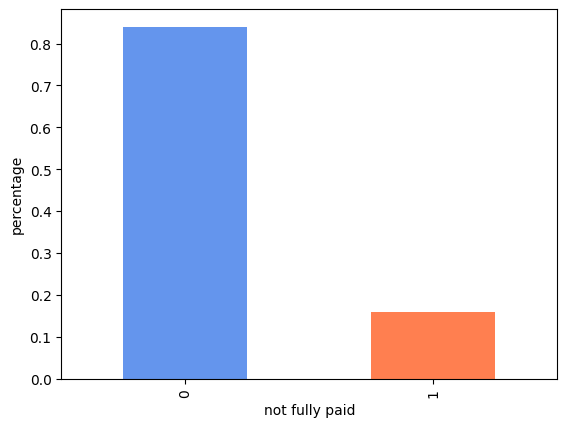

In [ ]:
# Let's take a look at the distribution of the target
y_train.value_counts(normalize=True).plot(kind='bar', color=['cornflowerblue', 'coral'])
plt.xlabel('not fully paid')
plt.ylabel('percentage');

The graph shows our target has a binary class (0 and 1). Close to 84% of the instances are labeled as fully paid (class 0) and about 16% are labeled as not fully paid (class 1). This indicates an imbalanced class distribution.

## III. Establish Baseline

The baseline refers to the score or performance that we would achieve by simply guessing or using a basic rule without any predictive modeling. It serves as a reference point to evaluate the effectiveness of our predictive models.

In our classification problem with binary classes, when we are predicting whether a loan is fully paid or not, the baseline can be determined by the majority class frequency. If the majority class frequency is between 50% and 70%, we can use accuracy as the evaluation metric for our models. Accuracy represents the proportion of correct predictions out of the total predictions made.

However, if the majority class frequency is below 50% or above 70%, accuracy alone may be misleading as a performance metric. In such cases, we would need to consider additional evaluation metrics that take into account the class imbalance and focus on the specific problem goals, such as precision, recall, or F1-score.

In [ ]:
# Majority Class
print('Majority Class:', y_train.value_counts(normalize=True).idxmax())

Majority Class: 0


In [ ]:
# Assuming y_train contains the true labels for the training set
baseline_guess = [0] * len(y_train)  # Assigning 0 (majority class) to all instances
baseline_f1_score = f1_score(y_train, baseline_guess)

print("Baseline F1-score:", baseline_f1_score)


Baseline F1-score: 0.0


In [ ]:
print('Baseline accuracy', y_train.value_counts(normalize=True).max())

Baseline accuracy 0.8397285304098147


In our case, the majority class frequency is above 70% so the accuracy metric would be misleading. For this reason, we have decided to evaluate our model using F1-score.

The baseline F1-score of 0.0 suggests that the baseline guess, which assigns the majority class label to all instances, does not correctly identify any instances of the minority class ('not_fully_paid' = 1). This is expected since the baseline guess does not account for any patterns or features in the data.

When building our model, the goal is to achieve an F1-score higher than the baseline score, indicating that our model performs better than the simple baseline guess.

## IV. Build Model and Evaluate Metrics

We are going to build two models for training and tuning:
- Logistic Regression
- Random Forest

**We are going to evaluate the models using F1-score**, which is a combined metric that balances both precision and recall, making it a useful evaluation metric for imbalanced classification tasks like predicting loan defaults.

The F1 score takes into account both false positives (incorrectly approving loans to potential defaulters) and false negatives (missing out on potential good borrowers). By optimizing the F1 score, we aim to strike a balance between minimizing the risk of default (precision) and not rejecting creditworthy borrowers (recall).

### Model 1A - Logistic Regression (Imbalanced)

In [ ]:
%%time
# Model 1a - Imbalanced LR

# Define the column transformer with different transformers for different column types
preprocessor = ColumnTransformer([
    ('numeric', StandardScaler(), ['credit_policy', 'int_rate', 'installment', 'log_annual_inc', 'dti','days_with_cr_line',
                                   'revol_bal', 'delinq_2yrs', 'pub_rec', 'multiple_hard_inq', 'cr_util_rate']),
    ('categorical', OneHotEncoder(), ['purpose', 'credit_score_cat']),
])

# Create the pipeline
imb_lr_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42))
])

# Fit the model
imb_lr_model.fit(X_train, y_train)

# Evaluate the model using cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(imb_lr_model, X_train, y_train, cv=cv, scoring='f1')
print('Cross-Validation Scores:', scores)
print('F1-score Imbalanced LR:', np.mean(scores))

Cross-Validation Scores: [0.03891051 0.03149606 0.03921569 0.0546875  0.0610687 ]
F1-score Imbalanced LR: 0.0450756914786576
CPU times: user 530 ms, sys: 583 ms, total: 1.11 s
Wall time: 1.02 s


In [ ]:
# Perform cross-validation and obtain predicted labels
imb_lr_y_pred = cross_val_predict(imb_lr_model, X_train, y_train, cv=cv)
# Imbalanced Random Forest Classification Report
print('Imbalanced LR Classification Report: ')
print(classification_report(y_train, imb_lr_y_pred))

Imbalanced LR Classification Report: 
              precision    recall  f1-score   support

           0       0.84      1.00      0.91      6434
           1       0.52      0.02      0.05      1228

    accuracy                           0.84      7662
   macro avg       0.68      0.51      0.48      7662
weighted avg       0.79      0.84      0.77      7662



### Model 2A - Random Forest (Imbalanced)

In [ ]:
%%time
# Model 2a - Imbalanced RF

# Define the column transformer with different transformers for different column types
preprocessor = ColumnTransformer([
    ('numeric', StandardScaler(), ['credit_policy', 'int_rate', 'installment', 'log_annual_inc','dti', 'days_with_cr_line',
                                   'revol_bal','delinq_2yrs', 'pub_rec', 'multiple_hard_inq', 'cr_util_rate']),
    ('categorical', OneHotEncoder(), ['purpose', 'credit_score_cat']),
])

# Create the pipeline
imb_rf_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Fit the model
imb_rf_model.fit(X_train, y_train)

# Evaluate the model using cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(imb_rf_model, X_train, y_train, cv=cv, scoring='f1')
print('Cross-Validation Scores:', scores)
print('F1-score Imbalanced RF:', np.mean(scores))

Cross-Validation Scores: [0.06153846 0.04669261 0.046875   0.0530303  0.06766917]
F1-score Imbalanced RF: 0.05516110890099729
CPU times: user 10 s, sys: 61.3 ms, total: 10.1 s
Wall time: 16.1 s


In [ ]:
# Perform cross-validation and obtain predicted labels
imb_rf_y_pred = cross_val_predict(imb_rf_model, X_train, y_train, cv=cv)
# Imbalanced Random Forest Classification Report
print('Imbalanced RF Classification Report: ')
print(classification_report(y_train, imb_rf_y_pred))

Imbalanced RF Classification Report: 
              precision    recall  f1-score   support

           0       0.84      0.99      0.91      6434
           1       0.48      0.03      0.06      1228

    accuracy                           0.84      7662
   macro avg       0.66      0.51      0.48      7662
weighted avg       0.78      0.84      0.77      7662



Based on the provided classification reports, it appears that both the Logistic Regression (LR) and Random Forest (RF) models outperformed the baseline. The **F1-scores** for the minority class (class 1 - not fully paid loans) of 0.05 and 0.06 indicate that the models are capturing some predictive power and performing better than random guessing. However, they are not performing well in identifying potential loan defaulters.


The **precision** for the minority class is 0.52 for the Imbalanced LR model and 0.48 for the Imbalanced RF model. This means that out of the loans predicted as not fully paid, only about 52% and 48% are actually defaulters, respectively.

The **recall** for the minority class is 0.02 for the Imbalanced LR model and 0.03 for the Imbalanced RF model. This indicates that the models are missing a significant number of defaulters, as they have low recall rates.

**The overall accuracy of both models is relatively high, around 84%, but this can be misleading in imbalanced datasets where the majority class dominates.**

The **macro-average F1-scores** is 0.48 for both models, which shows the poor performance of the models in capturing the minority class.

It is evident that the models need improvement in correctly identifying defaulters. Balancing the class distribution through techniques like undersampling the majority class, oversampling the minority class, or using advanced methods like SMOTE (Synthetic Minority Over-sampling Technique) could potentially enhance the model's performance.

## V. SMOTE Technique for Fixing the Imbalanced Class


Since we have a severe imbalance problem, we need to re-balance our data using synthetic minority oversampling technique (SMOTE). It uses characteristics of nearest neighbors of minority class examples to replicate new ones that are quite similar to the existing observations in the minority class.  

### Model 1B - Logistic Regression (Balanced)

In [ ]:
%%time
# Model 1b : Logistic Regression - Balanced Data

# Define the column transformer with different transformers for different column types
preprocessor = ColumnTransformer([
    ('numeric', StandardScaler(), ['credit_policy', 'int_rate', 'installment', 'log_annual_inc','dti','days_with_cr_line',
                                   'revol_bal', 'delinq_2yrs', 'pub_rec', 'multiple_hard_inq', 'cr_util_rate']),
    ('categorical', OneHotEncoder(), ['purpose', 'credit_score_cat']),
])

# Create the pipeline
bal_lr_model = Pipeline([
    ('preprocessor', preprocessor),
    ('oversampling', SMOTE(sampling_strategy='auto', random_state=42)),
    ('undersampling', RandomUnderSampler(sampling_strategy='auto', random_state=42)),
    ('classifier', LogisticRegression(random_state=42))
])

# Fit the model
bal_lr_model.fit(X_train, y_train)

# Evaluate the model using cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
bal_lr_scores = cross_val_score(bal_lr_model, X_train, y_train, cv=cv, scoring='f1')
print('Cross-Validation Scores:', bal_lr_scores)
print('F1-score Balanced LR:', np.mean(bal_lr_scores))

Cross-Validation Scores: [0.33084577 0.36296296 0.34651163 0.33333333 0.34251497]
F1-score Balanced LR: 0.34323373308148636
CPU times: user 967 ms, sys: 521 ms, total: 1.49 s
Wall time: 797 ms


In [ ]:
# Perform cross-validation and obtain predicted labels
bal_lr_y_pred = cross_val_predict(bal_lr_model, X_train, y_train, cv=cv)
# Imbalanced Random Forest Classification Report
print('Balanced LR Classification Report: ')
print(classification_report(y_train, bal_lr_y_pred))

Balanced LR Classification Report: 
              precision    recall  f1-score   support

           0       0.89      0.65      0.75      6434
           1       0.24      0.58      0.34      1228

    accuracy                           0.64      7662
   macro avg       0.57      0.62      0.55      7662
weighted avg       0.79      0.64      0.69      7662



### Model 2B - Random Forest (Balanced)

In [ ]:
%%time
# Model 2b : Random Forest - Balanced Data

# Define the column transformer with different transformers for different column types
preprocessor = ColumnTransformer([
    ('numeric', StandardScaler(), ['credit_policy', 'int_rate', 'installment', 'log_annual_inc', 'dti','days_with_cr_line',
                                   'revol_bal', 'delinq_2yrs', 'pub_rec', 'multiple_hard_inq', 'cr_util_rate']),
    ('categorical', OneHotEncoder(), ['purpose', 'credit_score_cat']),
])

# Create the pipeline
bal_rf_model = Pipeline([
    ('preprocessor', preprocessor),
    ('oversampling', SMOTE(sampling_strategy='auto', random_state=42)),
    ('undersampling', RandomUnderSampler(sampling_strategy='auto', random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Fit the model
bal_rf_model.fit(X_train, y_train)

# Evaluate the model using cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
bal_rf_scores = cross_val_score(bal_rf_model, X_train, y_train, cv=cv, scoring='f1')
print('Cross-Validation Scores:', bal_rf_scores)
print('F1-score Balanced RF:', np.mean(bal_rf_scores))

Cross-Validation Scores: [0.16541353 0.21243523 0.19170984 0.23501199 0.19211823]
F1-score Balanced RF: 0.19933776571269055
CPU times: user 13.2 s, sys: 176 ms, total: 13.3 s
Wall time: 13.2 s


In [ ]:
%%time
# Perform cross-validation and obtain predicted labels
bal_rf_y_pred = cross_val_predict(bal_rf_model, X_train, y_train, cv=cv)
# Imbalanced Random Forest Classification Report
print('Balanced RF Classification Report: ')
print(classification_report(y_train, bal_rf_y_pred))

Balanced RF Classification Report: 
              precision    recall  f1-score   support

           0       0.85      0.91      0.88      6434
           1       0.26      0.16      0.20      1228

    accuracy                           0.79      7662
   macro avg       0.56      0.54      0.54      7662
weighted avg       0.76      0.79      0.77      7662

CPU times: user 10.3 s, sys: 74.3 ms, total: 10.3 s
Wall time: 10.2 s


After applying a balanced approach to address the class imbalance issue, the F1-scores for the minority class (class 1 - not fully paid loans) have improved for both the Balanced LR and Balanced RF models.

**The F1-score for the minority class is 0.34 for the Balanced LR model and 0.20 for the Balanced RF model. Although there is an improvement compared to the imbalanced models, the F1-scores are still relatively low, indicating the need for further improvement in capturing defaulters.**

The **precision** for the minority class is 0.24 for the Balanced LR model and 0.26 for the Balanced RF model. This means that out of the loans predicted as not fully paid, approximately 24% and 26% are actually defaulters, respectively.

The **recall** for the minority class is 0.58 for the Balanced LR model and 0.16 for the Balanced RF model. This shows that the Balanced LR model has improved in capturing a higher proportion of defaulters compared to the Balanced RF model.

**The overall accuracy of the models has decreased compared to the imbalanced models, which is expected when focusing on improving performance for the minority class.** The accuracy is around 64% for the Balanced LR model and 79% for the Balanced RF model.

## VI. Hyperparameter Tuning

Perform hyperparameter tuning on balanced models using randomized search technique. Explore various hyperparameter combinations and select the set of hyperparameters that maximizes the F1-score.



In [ ]:
%%time
# Define the parameter grid for tuning the LR model
param_grid = {
    'classifier__C': np.logspace(0, 5, 10),
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear', 'saga'],
    'classifier__max_iter': [100, 500, 1000, 1500, 5000],
    'preprocessor__numeric__with_mean': [True, False]
}

# Create the RandomizedSearchCV object
random_search_lr = RandomizedSearchCV(
    estimator=bal_lr_model,
    param_distributions=param_grid,
    scoring='f1',
    cv=5,
    n_iter=10,  # Number of random combinations to try
    random_state=42,
    verbose=1
)

# Fit the model with hyperparameter tuning
random_search_lr.fit(X_train, y_train)

# Get the best hyperparameters and the best F1-score
best_params = random_search_lr.best_params_
best_score = random_search_lr.best_score_

print('Best Hyperparameters:', best_params)
print('Best F1-score:', best_score)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Hyperparameters: {'preprocessor__numeric__with_mean': False, 'classifier__solver': 'liblinear', 'classifier__penalty': 'l1', 'classifier__max_iter': 5000, 'classifier__C': 1.0}
Best F1-score: 0.33639824934444984
CPU times: user 42.8 s, sys: 4.2 s, total: 47 s
Wall time: 41.5 s


In [ ]:
%%time
# Perform cross-validation and obtain predicted labels
rs_lr_y_pred = cross_val_predict(random_search_lr, X_train, y_train, cv=cv)

# Tuned Random Forest Classification Report
print('Tuned LR Classification Report: ')
print(classification_report(y_train, rs_lr_y_pred))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Tuned LR Classification Report: 
              precision    recall  f1-score   support

           0       0.89      0.66      0.76      6434
           1       0.24      0.58      0.34      1228

    accuracy                           0.64      7662
   macro avg       0.57      0.62      0.55      7662
weighted avg       0.79      0.64      0.69      7662

CPU times: user 2min 44s, sys: 20.5 s, total: 3min 5s
Wall time: 2min 40s


Based on the classification reports, it appears that the hyperparameter tuning for the logistic regression model did not lead to a significant improvement in the performance metrics. The precision, recall, and F1-score for both classes are similar before and after tuning. The accuracy and macro-average F1-score also remain unchanged.

However, it's worth noting that hyperparameter tuning doesn't always guarantee significant improvements in model performance. It's possible that the logistic regression model may not be able to capture the underlying patterns in the data effectively, leading to limited improvements even with hyperparameter tuning.

In [ ]:
%%time

# Define the parameter grid for tuning the RF model
param_grid = {
    'classifier__n_estimators': range(100, 1000, 10),
    'classifier__max_features': ['log2', 'sqrt', None],
    'classifier__max_depth': [None, 5, 10, 15],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__bootstrap': [True, False]
}

# Create the RandomizedSearchCV object
random_search_rf = RandomizedSearchCV(
    estimator=bal_rf_model,
    param_distributions=param_grid,
    scoring='f1',
    cv=5,
    n_iter=10,  # Number of random combinations to try
    random_state=42,
    verbose=1
)

# Fit the model with hyperparameter tuning
random_search_rf.fit(X_train, y_train)

# Get the best hyperparameters and the best F1-score
best_params = random_search_rf.best_params_
best_score = random_search_rf.best_score_

print('Best Hyperparameters:', best_params)
print('Best F1-score:', best_score)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Hyperparameters: {'classifier__n_estimators': 600, 'classifier__min_samples_split': 2, 'classifier__max_features': 'log2', 'classifier__max_depth': 5, 'classifier__bootstrap': True}
Best F1-score: 0.3260676790180826
CPU times: user 15min 26s, sys: 1.89 s, total: 15min 28s
Wall time: 15min 28s


In [ ]:
%%time
# Perform cross-validation and obtain predicted labels
rs_rf_y_pred = cross_val_predict(random_search_rf, X_train, y_train, cv=cv)

# Tuned Random Forest Classification Report
print('Tuned RF Classification Report: ')
print(classification_report(y_train, rs_rf_y_pred))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Tuned RF Classification Report: 
              precision    recall  f1-score   support

           0       0.88      0.77      0.82      6434
           1       0.26      0.44      0.33      1228

    accuracy                           0.71      7662
   macro avg       0.57      0.60      0.57      7662
weighted avg       0.78      0.71      0.74      7662

CPU times: user 1h 11s, sys: 5.38 s, total: 1h 16s
Wall time: 1h 15s


Based on the classification reports, it seems that the hyperparameter tuning for the random forest model led to improvements in the performance metrics. After tuning, the precision, recall, and F1-score for both classes have improved compared to the untuned model. The accuracy, macro-average F1-score, and weighted-average F1-score have also increased.

**Before tuning:**

- Class 0 precision: 0.85, recall: 0.91, F1-score: 0.88
- Class 1 precision: 0.26, recall: 0.16, F1-score: 0.20

**After tuning:**

- Class 0 precision: 0.88, recall: 0.77, F1-score: 0.82
- Class 1 precision: 0.26, recall: 0.44, F1-score: 0.33

It's worth mentioning that the hyperparameter tuning process for the random forest model took a significant amount of time, as indicated by the CPU times. This is expected for a large number of fits and can be computationally intensive.

However, the tuned random forest model shows improvements in performance, particularly in the recall and F1-score for the minority class (class 1). It suggests that the model is better at correctly identifying the positive cases, although there is still room for improvement.

We can also see that the tuned RF model outperforms the tuned LR model in most of the metrics.

The tuned RF model has a higher accuracy (0.71) compared to the tuned LR model (0.64), indicating that it makes more accurate predictions overall.

In terms of F1-score, the tuned RF model has a higher weighted average F1-score (0.74) compared to the tuned LR model (0.69). The weighted average takes into account class imbalances, providing a more representative measure of overall model performance.
